### Dataset Creation Pseudo Code

create 80k 8bit noisy images of size 128x128

For every noisy image:
    choose random number of MNIST samples
    
    For every random MNIST sample:
        randomly change size of sample
        randomly shear
        randomly change rotation of sample
        apply 1d gaussian noise
        
        overlay sample on large noisy image at random xy-coordinates (multiple samples per large noisy image)
        write coordinates to text file with same name as large noisy image
        write large noisy image to memory

The same pipeline will be applied to the test set and will number 20k.

### Dataset Split Description

The MNIST Dataset already has a train and a test set. The preexisting split will be used to ensure that there are no data leakage issues.

### Dataset

A Folder Dataset will be initialized using Pytorches Folder Dataset Class.

### Transforms

In addition to the previously mentioned augmentations, the dataset will undergo runtime transformations such as normalization and random rotation. The rotations will have to be minor, since overly rotating an image can cause some letters and numbers to be confused, such as 6s and 9s. 

### Dataloaders

The dataloader will be one that is compatible with Pytorch's dataset folder. The dataloader is where the transforms will defined.

In [1]:
##install libraies if don't exist
# !pip install opencv-python
# !pip install tqdm

##library imports
import os, gc
import shutil
import cv2
import scipy
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

CPU times: total: 828 ms
Wall time: 1.96 s


30

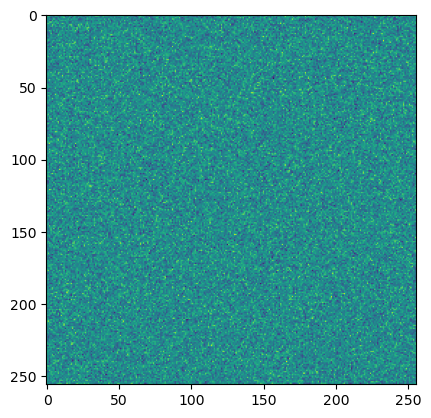

In [2]:
%%time

##define paths
datapath = "C:/Users/vanth/OneDrive/Desktop/JHUClasses/data/numbers_mnist/"
trainwrite = datapath + "/train/images/"
valwrite = datapath + "/val/images/"

def remove_path(path):
    '''
    Used for folder deletion and creation
    '''
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.makedirs(path)

def remove_file(path):
    '''
    Used for deletion of file only.
    '''
    if os.path.isfile(path):
        os.remove(path)
    
##if path exists then remove then make a new path
remove_path(trainwrite)
remove_path(trainwrite.replace('images', 'annotations'))
remove_path(valwrite)
remove_path(valwrite.replace('images', 'annotations'))

##read in trainset
train_df = pd.read_csv(datapath + 'mnist_train.csv')
y_train = train_df['label'].values
train_df = train_df.drop('label', axis=1, inplace=False)

##read in testset
val_df = pd.read_csv(datapath + 'mnist_test.csv')
y_val = val_df['label'].values
val_df = val_df.drop('label', axis=1, inplace=False)

##show an example of large noisy image
noise = np.random.normal(0, 50, 65536).reshape(256, -1)
plt.imshow(noise)
plt.savefig('lrg_noisy_img_ex.png')

##garbage collection
gc.collect()

In [3]:
def rand_gen_loc(img_shape, less_than_size):
    return int(np.random.uniform(low=0, high = (img_shape - less_than_size)))

def rand_gen_idx(idx_max):
    return int(np.random.uniform(low=0, high = (idx_max - 1)))

def rand_gen_imgcnt(num_imgs):
    return int(np.random.uniform(low=0, high = 10))

def write_labels(writepath, classes, xcoords, ycoords, sample_img_shape, noise_img_shape):
    '''
    In this implementation, the darknet label configuration is used, which means that the 
    xc and yc are the normalized center of the bbox, and height and width are also normalized.
    '''
    for i, (clss, xcoord, ycoord) in enumerate(zip(classes, xcoords, ycoords)):
        ##normalize width and height
        width, height = (sample_img_shape[0]/noise_img_shape[0], sample_img_shape[1]/noise_img_shape[1])
        
        ##normalize x and y coords
        xcoord = xcoord/noise_img_shape[0]
        ycoord = ycoord/noise_img_shape[1]

        ##write to string
        writestring1 = str(clss) + ' ' + str(xcoord) + ' ' + str(ycoord) + ' '
        writestring2 = str(width) + ' ' + str(height)
        if i < len(classes) - 1:
            writestring = writestring1 + writestring2 + '\n'
        else:
            writestring =  writestring1 + writestring2

        ##write to file - 1 per large noisy image with same name
        with open(writepath, 'a') as f:
            f.write(writestring)

##TODO
##randomly resize mnist samples
def create_dataset(gauss_sigma, num_noisy_imgs, savepath, data, target, is_train):
    ##keep track of the dataset to run statistics on
    data_dict = {'class': [], 'xcoord': [], 'ycoord': []}

    ##iterate through desired number of noisy images
    for i in tqdm(range(num_noisy_imgs), desc='Creating Dataset'):
        ##create new large and noisy image
        noise = np.random.normal(0, 50, 65536).reshape(256, -1)
        
        ##get random number of samples between 0 and 10 samples
        rand_smpl_cnt = rand_gen_imgcnt(10)

        ##define writename and left pad
        writepath = savepath + '/mnist_noise_' + str(i + 1).zfill(6)

        ##if random number of mnist samples was zero, then just write text file and random noise image
        if rand_smpl_cnt:
            ##iterate through random number of mnist samples
            classes, xcoords, ycoords = [], [], [] ##keep track of coords per large image
            for j in range(rand_smpl_cnt):
                ##get a random sample from the dataset
                rand_idx = rand_gen_idx(len(data))
                rand_sample = data.values[rand_idx].reshape(28, 28)
                rand_sample = scipy.ndimage.gaussian_filter1d(rand_sample, sigma=1) ##apply gaussian filter to random sample
            
                ##pick random x and y coordinates from large noisy image to put sample image
                randx = rand_gen_loc(noise.shape[0], rand_sample.shape[0])
                randy = rand_gen_loc(noise.shape[1], rand_sample.shape[1])
                
                if randx not in xcoords and randy not in ycoords:
                    noise[randy:randy + rand_sample.shape[1], randx: randx + rand_sample.shape[0]] = rand_sample

                    ##put in coco format
                    randxc = randx + 0.5*rand_sample.shape[0]
                    randyc = randy + 0.5*rand_sample.shape[1]

                    # if randxc >= 1:
                    #     print(randxc)
                    
                    ##document class and coordinate info to later use in associated .txt files
                    xcoords.append(randxc)
                    ycoords.append(randyc)
                    classes.append(target[rand_idx])
        
                    ##keep track of all of the coords and classes for dataset statistics
                    data_dict['xcoord'].append(randxc)
                    data_dict['ycoord'].append(randyc)
                    data_dict['class'].append(target[rand_idx])
            
            ##apply gaussian filter to entire image
            noise = scipy.ndimage.gaussian_filter1d(noise, sigma=gauss_sigma)
            cv2.imwrite(writepath + '.png', noise)

            ##check that there are objects to write
            if len(xcoords) and len(ycoords) and len(classes):
                ##DEBUG
                # print('sample shape: ', rand_sample.shape)
                # print('Noise img shape: ', noise.shape)
                write_labels(writepath.replace('images', 'annotations') + '.txt', classes, xcoords, ycoords, 
                             rand_sample.shape, noise.shape)
            else:
                with open(writepath.replace('images', 'annotations') + '.txt', 'a') as f:
                    f.write('')
        else:
            ##write large noisy image and empty file if num samples = 0
            noise = scipy.ndimage.gaussian_filter1d(noise, sigma=gauss_sigma)  #gauss filter
            cv2.imwrite(writepath + '.png', noise)
            with open(writepath.replace('images', 'annotations') + '.txt', 'a') as f:
                f.write('')
        
    ##show a sample image
    plt.imshow(noise)

    return data_dict

def write_img_paths(img_path, is_train):
    '''
    Write images to one text document as required by yv8
    '''
    print('Writing Image Paths to file.txt.')

    if is_train:
        designator = 'train.txt'
    else:
        designator = 'valid.txt'
    
    ##remove file if it exists
    remove_file(img_path.split('images/')[0] + designator)
    
    ##iterate over all image files and write to txt file
    files = os.listdir(img_path)
    for i, file in enumerate(files):

        ##check if train or valid
        if '.png' in file:
            
            ##create a new file
            with open(img_path.split('images/')[0] + designator, 'a') as f:
                if i < len(files) - 1:
                    f.write(img_path + file + '\n')
                else:
                    f.write(img_path + file)
            

Creating Dataset: 100%|█████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 278.53it/s]


Writing Image Paths to file.txt.
CPU times: total: 438 ms
Wall time: 3.07 s


3296

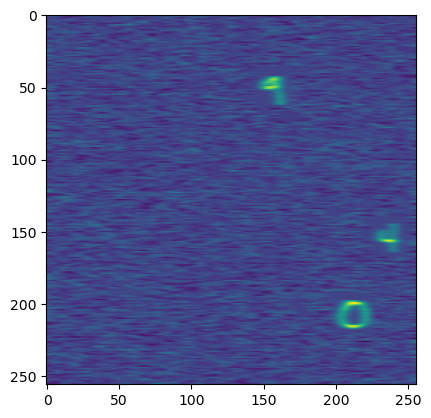

In [4]:
%%time

##preproc hyperparameters 
gauss_sigma = 3
num_train_imgs = 800

##create train dataset
train_dict = create_dataset(gauss_sigma, num_train_imgs, trainwrite, train_df, y_train, is_train=True)
write_img_paths(trainwrite, is_train=True)

gc.collect()

Creating Dataset: 100%|███████████████████████████████████████████████████████████| 1200/1200 [00:04<00:00, 283.95it/s]


Writing Image Paths to file.txt.
CPU times: total: 469 ms
Wall time: 4.39 s


3301

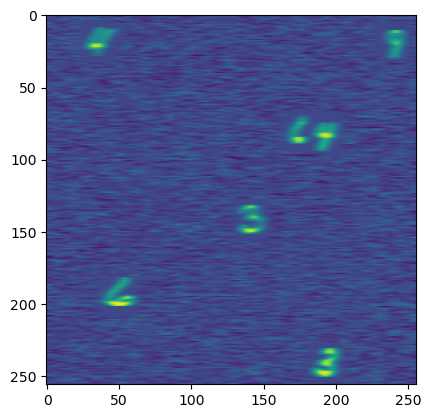

In [5]:
%%time

##preproc hyperparameters 
gauss_sigma = 3
num_test_imgs = 1200

##create test dataset
val_dict = create_dataset(gauss_sigma, num_test_imgs, valwrite, val_df, y_val, is_train=False)
write_img_paths(valwrite, is_train=False)

gc.collect()


Train Data Summary
CPU times: total: 15.6 ms
Wall time: 81.6 ms


3516

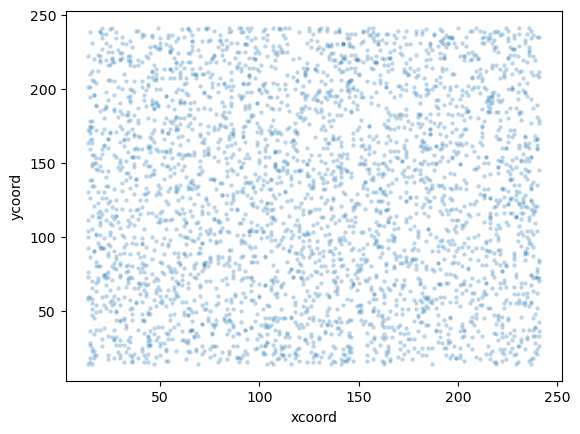

In [6]:
%%time

##run stats on trainset
train_stats_df = pd.DataFrame(train_dict)
print('\nTrain Data Summary')
train_stats_df.describe()

##show distribution of center of bboxes
fig, axes = plt.subplots(1, 1)
sns.scatterplot(data=train_stats_df, x='xcoord', y='ycoord', ax = axes, s=10, alpha=0.3)

gc.collect()


Val Data Summary
CPU times: total: 0 ns
Wall time: 84.7 ms


3356

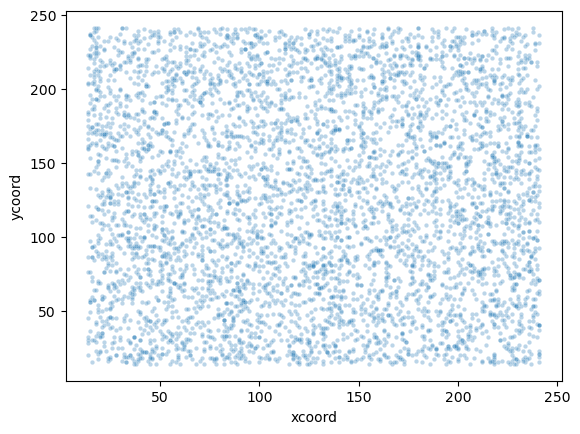

In [7]:
%%time

##run stats on trainset
val_stats_df = pd.DataFrame(val_dict)
print('\nVal Data Summary')
val_stats_df.describe()

##show distribution of center of bboxes
fig, axes = plt.subplots(1, 1)
sns.scatterplot(data=val_stats_df, x='xcoord', y='ycoord', ax = axes, s=10, alpha=0.3)

gc.collect()

['5 0.84765625 0.4609375 0.109375 0.109375\n', '8 0.8984375 0.84765625 0.109375 0.109375\n', '0 0.30859375 0.23046875 0.109375 0.109375\n', '2 0.47265625 0.484375 0.109375 0.109375']


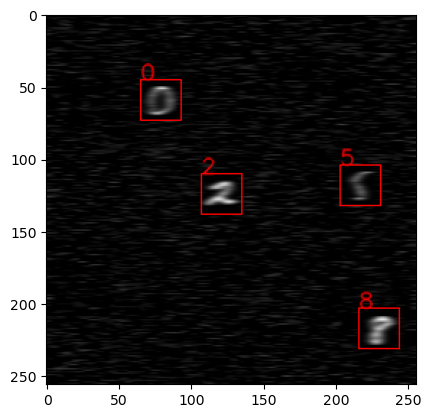

In [8]:
##check that the images have the correct bboxes
def check_bboxes(img_path):
    '''
    Checks that the bboxes make sense when overlaid on large noisy image.
    Opencv's indexing is image[y, x] instead of image[x, y]
    '''
    ##read image
    img = cv2.imread(img_path)

    ##open annotations file
    with open(img_path.replace('.png', '.txt').replace('images', 'annotations'), 'r') as f:
        bboxes = f.readlines()
        print(bboxes)

    ##write bboxes on image
    for bbox in bboxes:
        ##these coordinates are the center of the bbox hence "xc", "yc", and width, height are of the small overlayed image
        clss, xc, yc, w, h = bbox.replace('\n', '').split(' ')

        ##convert to upper left x, upper left y to view the bboxes using opencv format
        x1 = (float(xc) - 0.5*float(w))*img.shape[0]
        y1 = (float(yc) - 0.5*float(h))*img.shape[1]
        w, h = float(w)*img.shape[0], float(h)*img.shape[1]
    
        ##write rectangle
        start = (int(x1), int(y1))
        end = (int(x1) + int(w), int(y1) + int(h))
        img = cv2.rectangle(img, start, end, 255, 1)

        ###write class
        font = cv2.FONT_HERSHEY_SIMPLEX
        origin = (int(x1), int(y1))
        fontScale = 0.5
        color = 255
        thickness = 1
        img = cv2.putText(img, clss, origin, font, fontScale, color, thickness, cv2.LINE_AA) 
    
    plt.imshow(img)

##check bboxes make sense
img_path = 'C:/Users/vanth/OneDrive/Desktop/JHUClasses/data/numbers_mnist/val/images/mnist_noise_000003.png'
check_bboxes(img_path)

### 